- make a classifier network that is as similar as possible to the umap subclass

In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load packages

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
from scipy import optimize

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [5]:
#from tfumap.load_datasets import load_MNIST, load_FMNIST, load_CIFAR10, load_MACOSKO, load_CASSINS
#X_train, X_test, X_valid, Y_train, Y_test, Y_valid  = load_MNIST()

In [6]:
labels_per_class = 5
n_validation = 1000
from sklearn.datasets import make_moons

In [7]:
X_train, Y_train = make_moons(n_samples=2000,noise=0.1)
X_train_flat = X_train
X_test, Y_test = make_moons(n_samples=1000,noise=0.1)
X_valid, Y_valid = make_moons(n_samples=1000,noise=0.1)
# mask labels
label_mask = np.concatenate([np.where(Y_train == i)[0][:labels_per_class] for i in np.unique(Y_train)])
Y_train_masked = np.ones(len(Y_train))*-1
Y_train_masked[label_mask] = Y_train[label_mask]
X_labeled = X_train[label_mask]
Y_labeled = Y_train[label_mask]

(2000, 10, 1000)

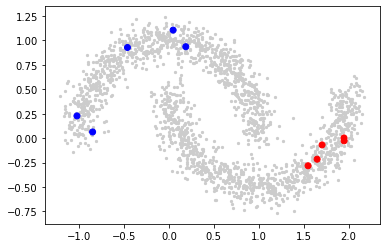

In [8]:
plt.scatter(X_train[:,0], X_train[:,1], color='#CCCCCC', s=5)
plt.scatter(X_labeled[:,0], X_labeled[:,1], c=Y_labeled, cmap = plt.cm.bwr)
len(X_train), len(X_labeled), len(X_valid)

### Build nearest neighbors graph

In [9]:
min_dist = 0.0 # default = 0.1
n_neighbors = 15 # default = 15

In [10]:
from pynndescent import NNDescent
from scipy.sparse import csr_matrix
from sklearn.utils import check_random_state
from umap.umap_ import fuzzy_simplicial_set
random_state = check_random_state(None)

In [11]:
n_trees = 5 + int(round((X_train_flat.shape[0]) ** 0.5 / 20.0))
n_iters = max(5, int(round(np.log2(X_train_flat.shape[0]))))

# get nearest neighbors
nnd = NNDescent(
    X_train_flat,
    n_neighbors=n_neighbors,
    metric='euclidean',
    n_trees=n_trees,
    n_iters=n_iters,
    max_candidates=60,
)

### Build fuzzy simplicial set

In [12]:
# get indices and distances
knn_indices, knn_dists = nnd.neighbor_graph

random_state = check_random_state(None)
# build graph
umap_graph, sigmas, rhos = fuzzy_simplicial_set(
    X = X_train_flat,
    n_neighbors = n_neighbors,
    metric = 'euclidean',
    random_state = random_state,
    knn_indices= knn_indices,
    knn_dists = knn_dists,
)
umap_graph

<2000x2000 sparse matrix of type '<class 'numpy.float32'>'
	with 33918 stored elements in Compressed Sparse Row format>

### Build data iterator

In [13]:
from tfumap.umap import compute_cross_entropy, get_graph_elements

In [14]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)

In [15]:
batch_size = np.min([n_vertices, 1000])
batch_size

1000

##### Labeled

In [16]:
def create_classification_iterator(X_labeled, y_labeled, batch_size):
    """
    Creates a tensorflow iterator for classification data (X, y)
    """
    #
    # create labeled data iterator
    labeled_data = tf.data.Dataset.from_tensor_slices((X_labeled, y_labeled))
    labeled_data = labeled_data.repeat()
    labeled_data = labeled_data.shuffle(np.min([len(y_labeled), 1000]))
    labeled_data = labeled_data.batch(batch_size)
    labeled_data = labeled_data.prefetch(buffer_size=1)

    return iter(labeled_data)

In [17]:
labeled_iter = create_classification_iterator(X_labeled, Y_labeled, batch_size=batch_size)

In [18]:
X, y = next(labeled_iter)
X.shape, y.shape

(TensorShape([1000, 2]), TensorShape([1000]))

##### Unlabeled

In [19]:
max_sample_repeats_per_epoch = 25

In [20]:
def batch_epoch_edges(edges_to, edges_from):
    """ permutes and batches edges for epoch
        """
    # compute the number of batches in one epoch
    n_batches = int(len(edges_to) / batch_size)
    # permute list of edges
    permutation_mask = np.random.permutation(len(edges_to))[: n_batches * batch_size]
    to_all = tf.reshape(tf.gather(edges_to, permutation_mask), (n_batches, batch_size))
    from_all = tf.reshape(
        tf.gather(edges_from, permutation_mask), (n_batches, batch_size)
    )
    # return a tensorflow dataset of one epoch's worth of batches
    return tf.data.Dataset.from_tensor_slices((to_all, from_all))


def create_edge_iterator(head, tail, weight, max_sample_repeats_per_epoch=25):
    """ create an iterator for edges
    """
    # set the maximum number of times each edge should be repeated per epoch
    epochs_per_sample = np.clip(
        (weight / np.max(weight)) * max_sample_repeats_per_epoch,
        1,
        max_sample_repeats_per_epoch,
    ).astype("int")

    edges_to_exp, edges_from_exp = (
        np.array([np.repeat(head, epochs_per_sample.astype("int"))]),
        np.array([np.repeat(tail, epochs_per_sample.astype("int"))]),
    )
    edge_iter = tf.data.Dataset.from_tensor_slices((edges_to_exp, edges_from_exp))
    edge_iter = edge_iter.repeat()
    edge_iter = edge_iter.map(batch_epoch_edges)
    edge_iter = edge_iter.prefetch(buffer_size=10)

    return iter(edge_iter), np.shape(edges_to_exp)[1]

In [21]:
edge_iter, n_edges_per_epoch = create_edge_iterator(head, tail, weight)

In [22]:
edge_iter, n_edges_per_epoch

(<tensorflow.python.data.ops.iterator_ops.OwnedIterator at 0x7f4d6890ba20>,
 280356)

In [23]:
edge_epoch = next(edge_iter)
for (batch_to, batch_from) in edge_epoch:
    break
batch_to.shape, batch_from.shape

(TensorShape([1000]), TensorShape([1000]))

##### validation

In [24]:
def create_validation_iterator(valid_X, valid_Y, batch_size):
    """ Create an iterator that returns validation X and Y
    """
    data_valid = tf.data.Dataset.from_tensor_slices((valid_X, valid_Y))
    data_valid = data_valid.cache()
    data_valid = data_valid.batch(batch_size)
    data_valid = data_valid.prefetch(buffer_size=1)

    return data_valid, len(valid_X)

In [25]:
data_valid, n_valid_samp = create_validation_iterator(X_valid, Y_valid, batch_size)

### Build network

In [26]:
from tensorflow.keras import layers

In [27]:
dims = (2)
num_classes = 2
PROJECTION_DIMS = 2

In [28]:
encoder = tf.keras.Sequential()
encoder.add(tf.keras.Input(shape=dims))
encoder.add(layers.Dense(10, activation='relu'))
encoder.add(layers.Dense(10, activation='relu'))
encoder.add(layers.Dense(10, activation='relu'))

In [29]:
classifier = tf.keras.Sequential()
classifier.add(tf.keras.Input(shape=(10)))
classifier.add(layers.Dense(10, activation='relu'))
classifier.add(layers.Dense(num_classes, activation=None, name="predictions"))

In [30]:
embedder = tf.keras.Sequential()
embedder.add(tf.keras.Input(shape=(10)))
embedder.add(layers.Dense(10, activation='relu'))
embedder.add(layers.Dense(PROJECTION_DIMS, activation=None, name='z'))

In [31]:
classifier(encoder(X))

W0724 12:11:41.260022 139974478976832 base_layer.py:1790] Layer dense is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[0.09083208, 0.11555456],
       [0.06875614, 0.09489409],
       [0.11000123, 0.18539916],
       ...,
       [0.05555223, 0.09419356],
       [0.09015629, 0.14198105],
       [0.07673232, 0.09729117]], dtype=float32)>

In [32]:
embedder(encoder(X))

<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[-0.15665424,  0.05716661],
       [-0.14636423,  0.05228541],
       [-0.01945702, -0.14309946],
       ...,
       [-0.02395006,  0.03772036],
       [-0.04528767,  0.06160617],
       [-0.13923703,  0.04995055]], dtype=float32)>

### Create UMAP object

In [33]:
from tfumap.umap import compute_cross_entropy, convert_distance_to_probability

In [34]:
def find_a_b(min_dist = 0.1):
    """ determine optimal params a, b to such that distances less than 
        min_dist have a probability of zero
    """
    # input distances
    x = np.linspace(0, 3, 300)
    # optimal output (if close enough, don't try to make closer)
    y = np.exp(-x + min_dist) * (x > min_dist) + (x < min_dist)

    # run through scipy,optimize a, b parameters for min_dist
    # get the optimal
    (a, b), _ = optimize.curve_fit(f=distance_to_probability, xdata=x, ydata=y)

    # a and b parameters for computing probability in low-d
    a = tf.constant(a, dtype=tf.float32,)
    b = tf.constant(b,dtype=tf.float32,)
    return a, b


def distance_to_probability(distances, a, b):
        """ convert distance representation into probability, 
            as a function of a, b params
        """
        return 1.0 / (1.0 + a*distances**(2*b))

In [35]:
class UMAP(tf.keras.Model):
    def __init__(self, min_dist=0.1, optimizer=tf.keras.optimizers.SGD(0.1), **kwargs):
        self.__dict__.update(kwargs)

        # optimizer for cross entropy minimization
        self.optimizer = optimizer
        self.classifier_optimizer = tf.keras.optimizers.Adam(0.01)

        # get a,b for current min_dist
        self._a, self._b = find_a_b(min_dist)

        # create a loss dictionary
        self.loss_df = pd.DataFrame(
            columns=[
                "epoch",
                "type_",
                "attraction_loss",
                "repellant_loss",
                "umap_loss",
                "classifier_loss",
            ]
        )

        # sparse categorical cross entropy
        self.sparse_ce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    def save_losses(self, losses, epoch, type_="training"):
        """ Save losses into a pandas dataframe
        """
        attraction_loss, repellant_loss, umap_loss, classifier_loss = losses

        # get average loss
        attraction_loss = tf.reduce_mean(attraction_loss).numpy()
        repellant_loss = tf.reduce_mean(repellant_loss).numpy()
        umap_loss = tf.reduce_mean(umap_loss).numpy()
        classifier_loss = tf.reduce_mean(classifier_loss).numpy()

        # save loss
        self.loss_df.loc[len(self.loss_df)] = [
            epoch,
            type_,
            attraction_loss,
            repellant_loss,
            umap_loss,
            classifier_loss,
        ]

    @tf.function
    def compute_umap_loss(self, batch_to, batch_from):
        """
        compute the cross entropy loss for learning embeddings

        Parameters
        ----------
        batch_to : tf.int or tf.float32
            Either X or the index locations of the embeddings for verticies (to)
        batch_from : tf.int or tf.float32
            Either X or the index locations of the embeddings for verticies (from)

        Returns
        -------
        ce_loss : tf.float
            cross entropy loss for UMAP
        embedding_to : tf.float
            embeddings for verticies (to)
        embedding_from : tf.float
            embeddings for verticies (from)
        """


        # encode
        embedding_to = self.embedder(self.encoder(batch_to))
        embedding_from = self.embedder(self.encoder(batch_from))

        # get negative samples
        embedding_neg_to = tf.repeat(embedding_to, self.negative_sample_rate, axis=0)
        repeat_neg = tf.repeat(embedding_from, self.negative_sample_rate, axis=0)
        embedding_neg_from = tf.gather(
            repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
        )

        #  distances between samples
        distance_embedding = tf.concat(
            [
                tf.norm(embedding_to - embedding_from, axis=1),
                tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
            ],
            axis=0,
        )

        # convert probabilities to distances
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, self._a, self._b
        )

        # treat positive samples as p=1, and negative samples as p=0
        probabilities_graph = tf.concat(
            [tf.ones(embedding_to.shape[0]), tf.zeros(embedding_neg_to.shape[0])],
            axis=0,
        )

        # cross entropy loss
        (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
            probabilities_graph,
            probabilities_distance,
            #repulsion_strength=self.repulsion_strength,
        )

        return (
            attraction_loss,
            repellant_loss,
            ce_loss,
        )

        return (
            attraction_loss,
            repellant_loss,
            umap_loss,
        )

    def compute_classifier_loss(self, X, y):
        """ compute the cross entropy loss for classification
        """
        d = self.classifier(self.encoder(X))
        return self.sparse_ce(y, d)

    # @tf.function
    def train(self, batch_to, batch_from, X, y, save_loss=False):
        """ One training step 
        Input are points and weights for positive and negative 
        samples for training. 
            
        """
        with tf.GradientTape() as umap_tape, tf.GradientTape() as class_tape:
            (attraction_loss, repellant_loss, umap_loss) = self.compute_umap_loss(
                batch_to, batch_from
            )

            classifier_loss = self.compute_classifier_loss(X, y)

        umap_grad = umap_tape.gradient(
            umap_loss,
            self.encoder.trainable_variables + self.embedder.trainable_variables,
        )

        # gradients are cliped in UMAP implementation. Any effect here?
        umap_grad = [tf.clip_by_value(grad, -4.0, 4.0) for grad in umap_grad]

        self.optimizer.apply_gradients(
            zip(
                umap_grad,
                self.encoder.trainable_variables + self.embedder.trainable_variables,
            )
        )

        class_grad = class_tape.gradient(
            classifier_loss, self.classifier.trainable_variables
        )

        # gradients are cliped in UMAP implementation. Any effect here?
        class_grad = [tf.clip_by_value(grad, -4.0, 4.0) for grad in class_grad]

        self.classifier_optimizer.apply_gradients(
            zip(class_grad, self.classifier.trainable_variables)
        )

        return (attraction_loss, repellant_loss, umap_loss, classifier_loss)

    # @tf.function
    def project_epoch(self, X):
        """ Train a batch in tensorflow
        """
        return [self.embedder(self.encoder(batch)) for batch in X]

In [36]:
### Initialize model
model = UMAP(
    MIN_DIST = 0.0,
    negative_sample_rate = 5, # how many negative samples per positive
    optimizer=tf.keras.optimizers.Adam(1e-2), # cross-entropy optimizer
    encoder=encoder,
    embedder=embedder,
    classifier=classifier,
)

### plotting results

In [37]:
# get embedding
nbatches = np.floor(len(X_valid)/batch_size).astype('int')
valid_x = (X_valid[:nbatches*batch_size].reshape([nbatches, batch_size] + list([dims]))).astype('float32')

In [38]:
def embed_data(X, batch_size):
    """ embed a set of points in X to Z
    """
    n_batch = int(np.ceil(len(X) / batch_size))
    return  np.vstack([
        model.embedder(
            model.encoder(np.array(X[ (i) * batch_size : (i + 1) * batch_size, :]))
        )
        for i in range(n_batch)
    ])

def make_contour():
    x_span = np.linspace(-2, 3, 100)
    y_span = np.linspace(-1, 1.5, 100)
    xx, yy = np.meshgrid(x_span, y_span)
    X_grid = np.array([xx.ravel(), yy.ravel()]).T
    decision_grid = classify_data(X_grid, batch_size = 100)
    return xx, yy, decision_grid

def classify_data(X, batch_size):
    """ Classify a set of points X
    """
    n_batch = int(np.ceil(len(X) / batch_size))
    predictions =   np.vstack([
        model.classifier(
            model.encoder(np.array(X[ (i) * batch_size : (i + 1) * batch_size, :]))
        )
        for i in range(n_batch)
    ])
    predictions = tf.nn.softmax(predictions).numpy()
    return  predictions[:,1] - predictions[:,0]

def get_decision_contour(ax):
    z = embed_data(X_valid, 100)
    xx, yy, decision_grid = make_contour()

    ax.contourf(
        xx,
        yy,
        decision_grid.reshape((100, 100)),
        cmap=plt.cm.coolwarm,
        alpha=0.5,
        levels=np.linspace(-1, 1, 10),
    )

    ax.scatter(X_train[:, 0], X_train[:, 1], color = 'grey', alpha = 1, s=5)
    ax.scatter(X_labeled[:, 0], X_labeled[:, 1], c = Y_labeled, cmap=plt.cm.coolwarm, s=50)
    ax.set_title('Decision contour')
    return ax

In [39]:
import seaborn as sns


def plot_results():
    """ Just a quick and ugly function for plotting results
    """

    embedding_train = np.vstack(
        model.project_epoch(tf.data.Dataset.from_tensor_slices((valid_x)))
    )
    embedding = embedding_train
    projection_type = "training_data"
    fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
    

    # plot embedding
    ax = axs.flatten()[0]
    ax.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=Y_valid.astype(int)[:len(embedding)],
        cmap="coolwarm",  # "tab10"
        s=2,
        alpha=0.25,
        rasterized=True,
    )
    ax.set_title(projection_type, fontsize=24)
    ax.axis('equal')

    # plot loss
    for i, element in zip(
        range(1, 5), ["attraction_loss", "repellant_loss", "umap_loss", "classifier_loss"]
    ):
        ax = axs.flatten()[i]

        sns.lineplot(
            x="epoch", y=element, hue="type_", data=model.loss_df, ax=ax, ci=None
        )
        ax.set_title(element, fontsize=24)
        ax.set_yscale('log')
    ax = get_decision_contour(axs.flatten()[5])
    plt.show()

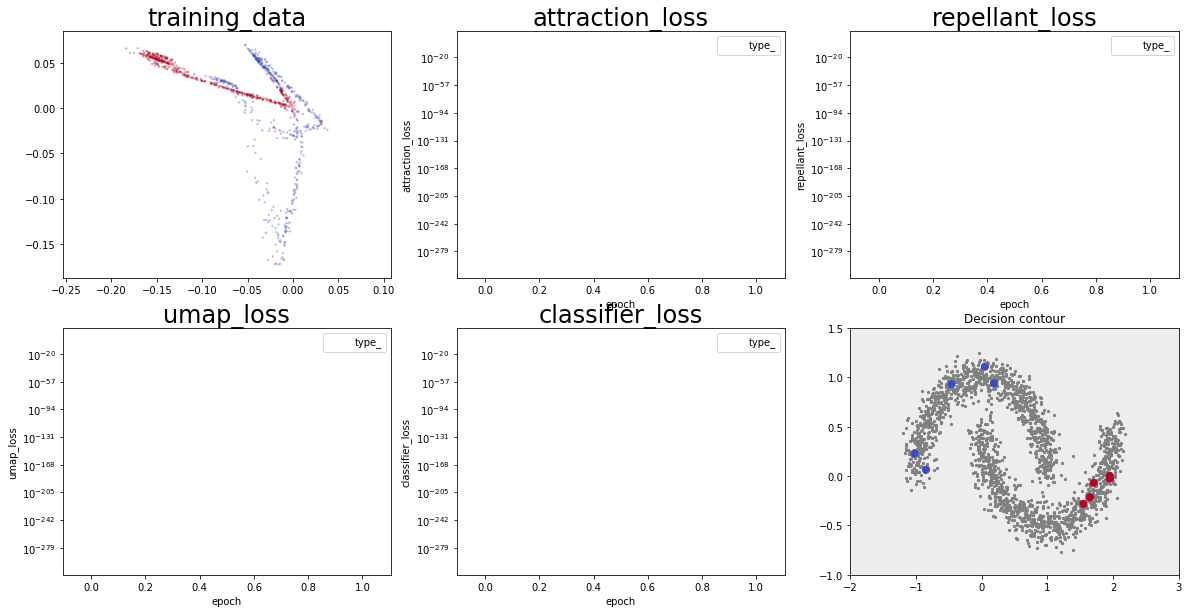

In [40]:
plot_results()

### Train model

In [41]:
batch = 0; epoch = 0
N_EPOCHS = 50 # total number of epochs
SAMPLE_EPOCHS = np.linspace(0, N_EPOCHS-1, 10).astype('int') # how often to plot
print(SAMPLE_EPOCHS[:10])
BATCHES_PER_EPOCH = int(n_edges_per_epoch / batch_size)
TOTAL_BATCHES = BATCHES_PER_EPOCH * N_EPOCHS

[ 0  5 10 16 21 27 32 38 43 49]


In [42]:
BATCHES_PER_EPOCH

280

In [43]:
edge_iter, data_valid, labeled_iter

(<tensorflow.python.data.ops.iterator_ops.OwnedIterator at 0x7f4d6890ba20>,
 <PrefetchDataset shapes: ((None, 2), (None,)), types: (tf.float64, tf.int64)>,
 <tensorflow.python.data.ops.iterator_ops.OwnedIterator at 0x7f4d69991a20>)

In [44]:
training_epochs = 20

batch: 0


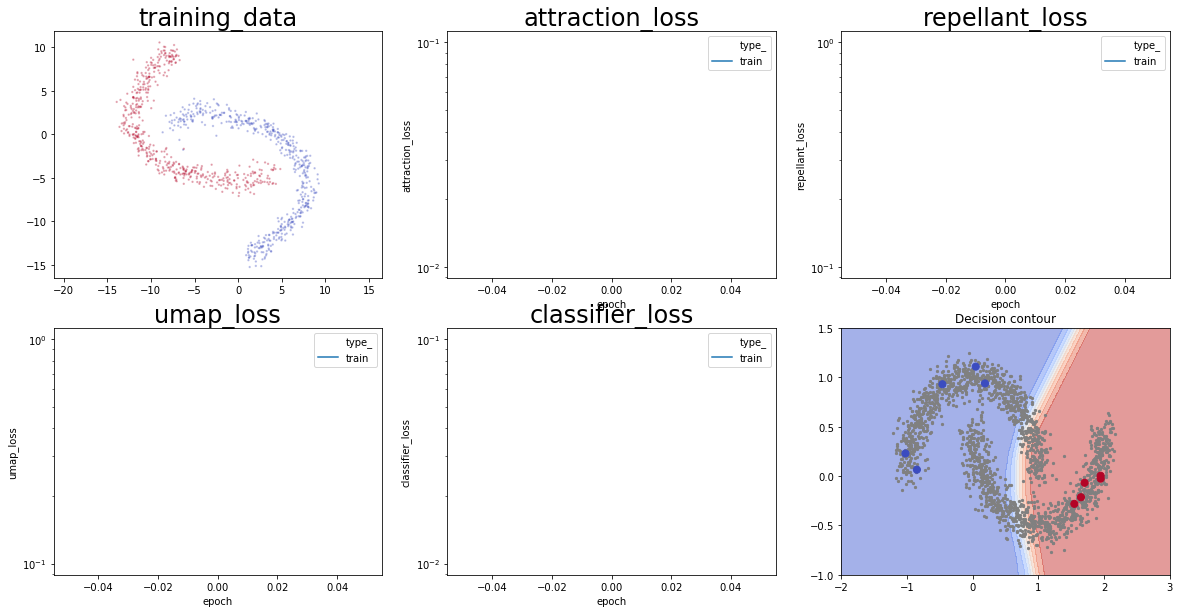

batch: 1400


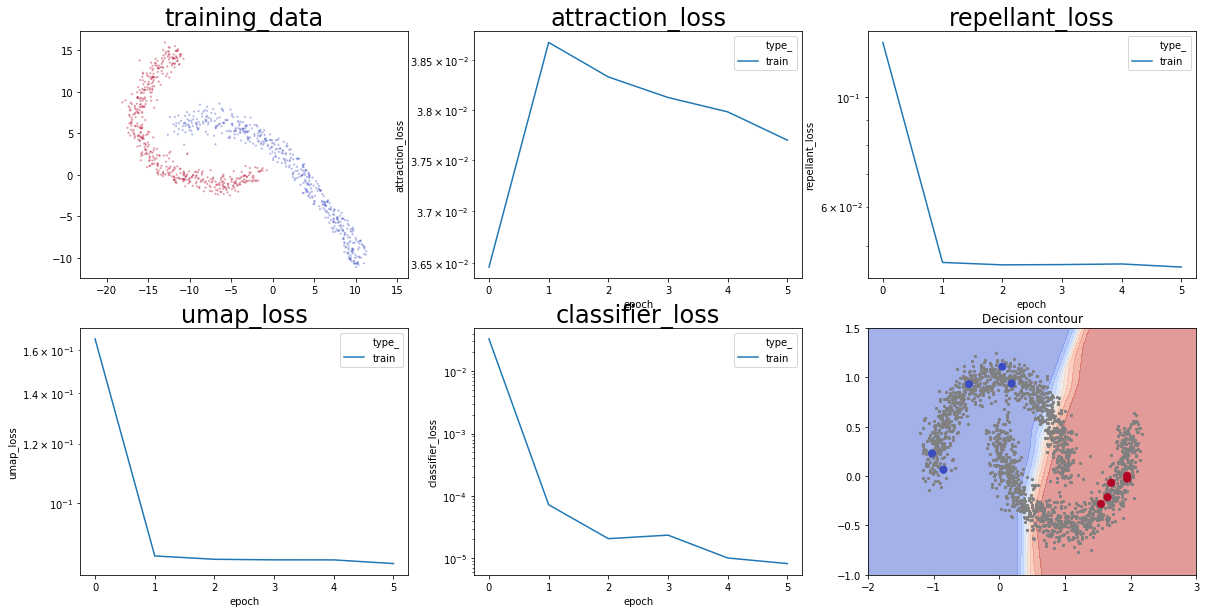

batch: 2800


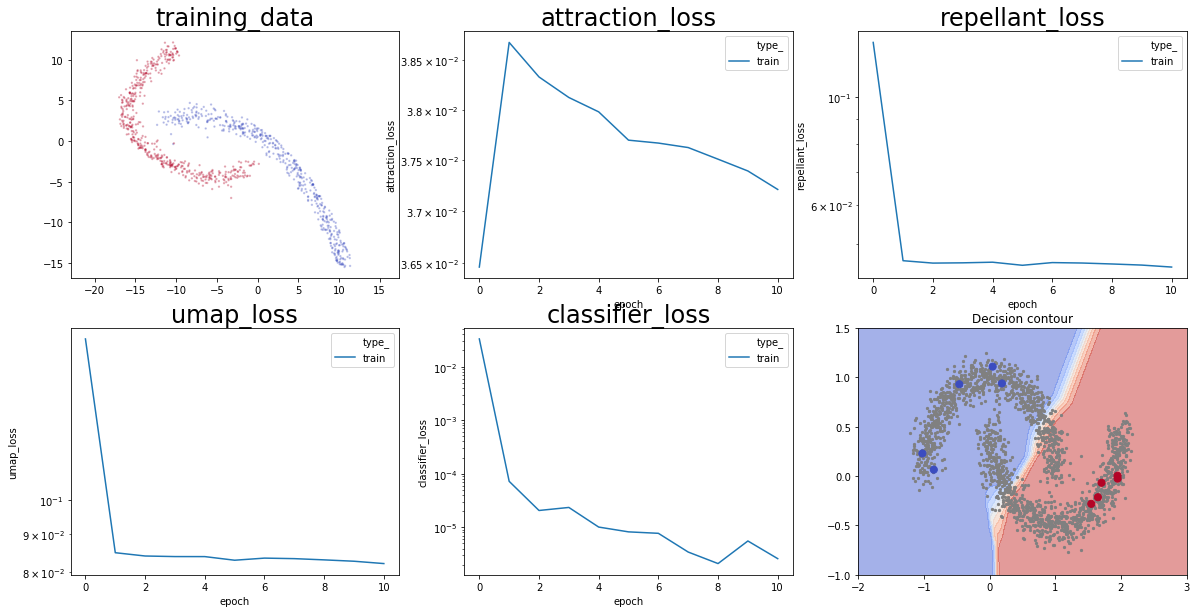

batch: 4480


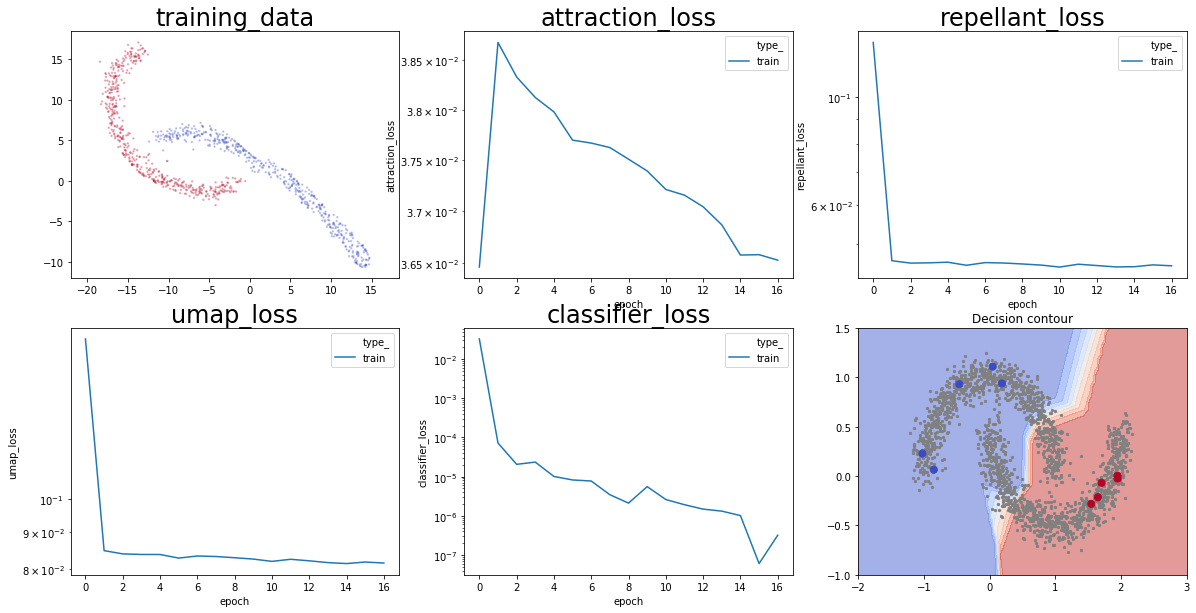

batch: 5880


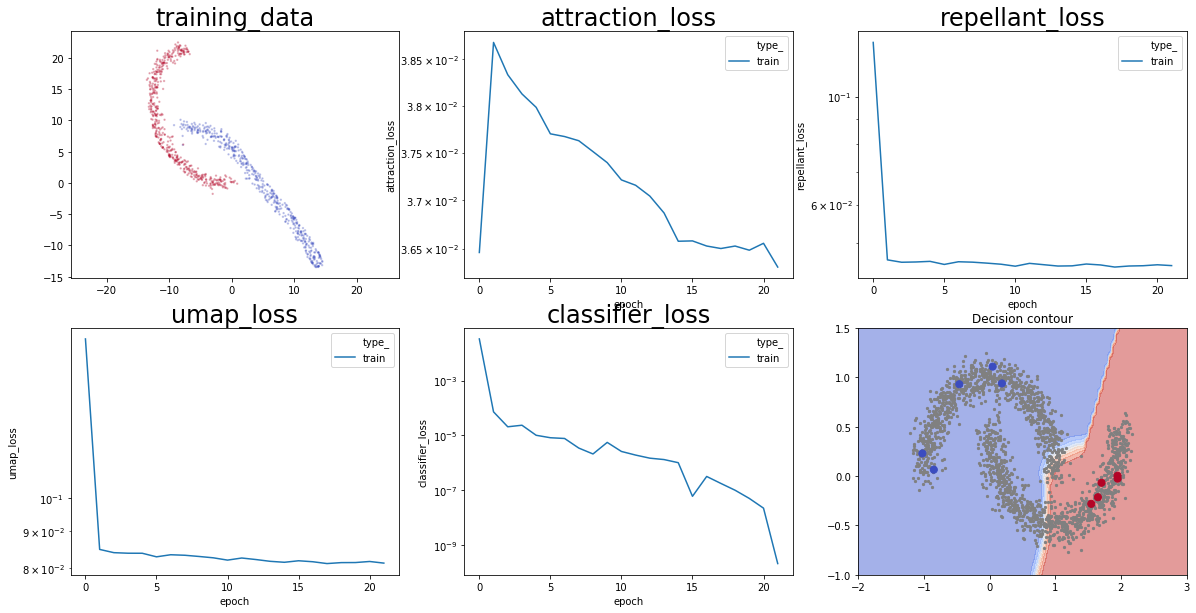

batch: 7560


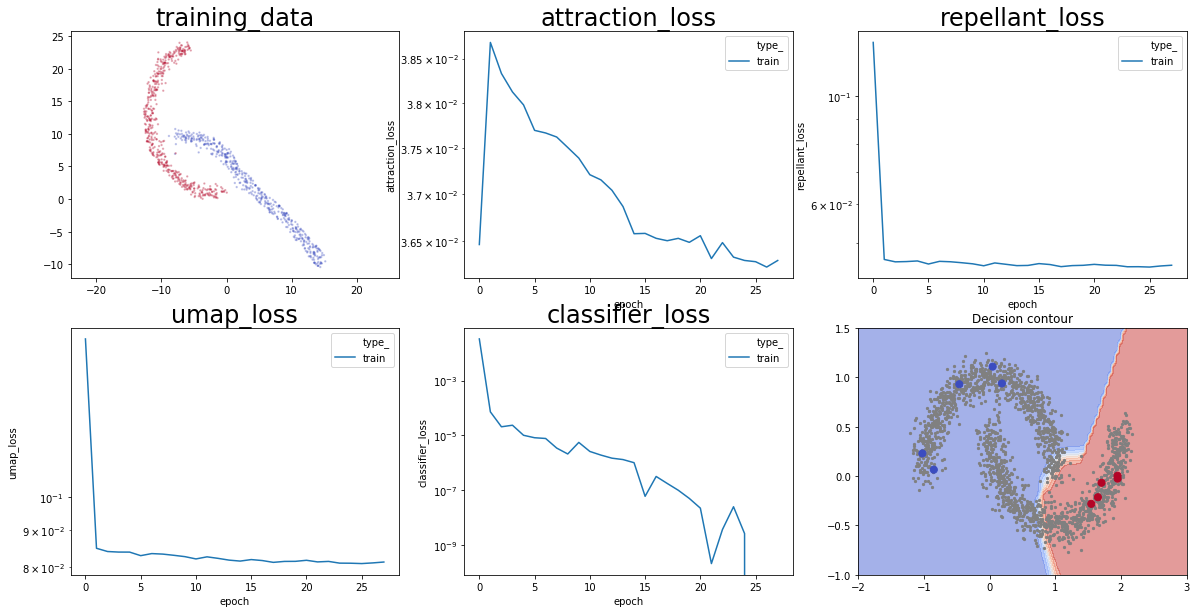

batch: 8960


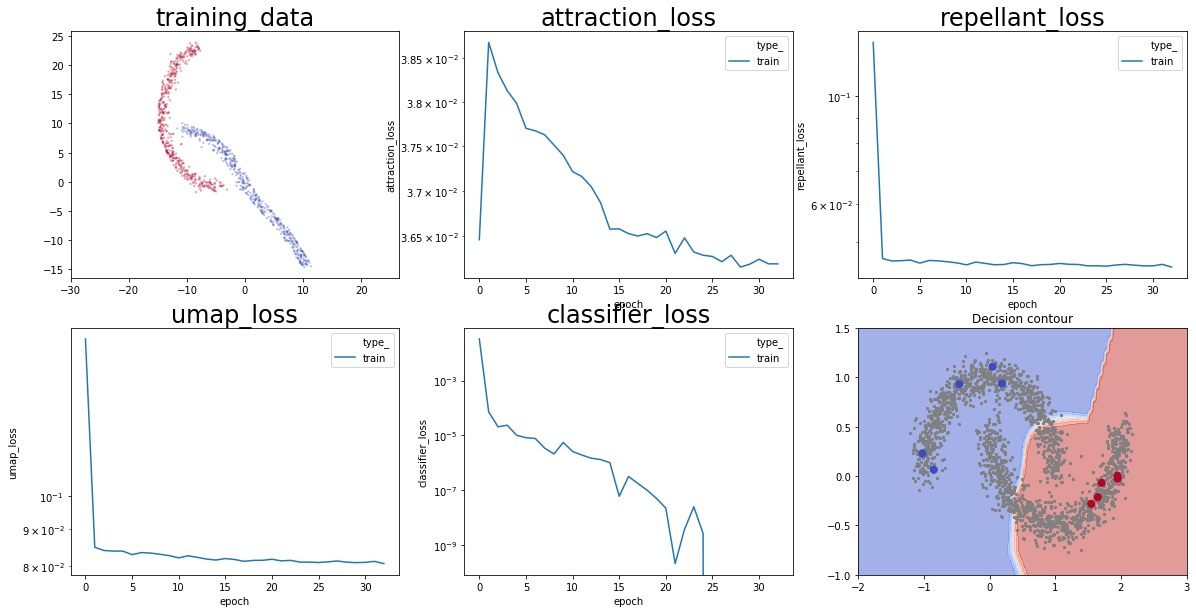

batch: 10640


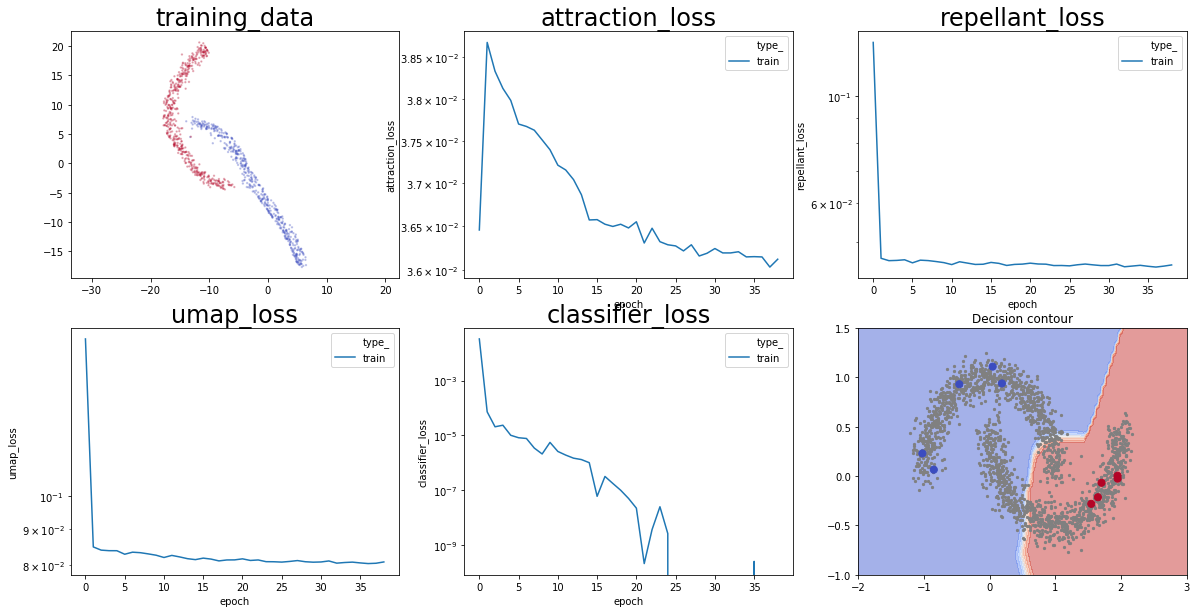

batch: 12040


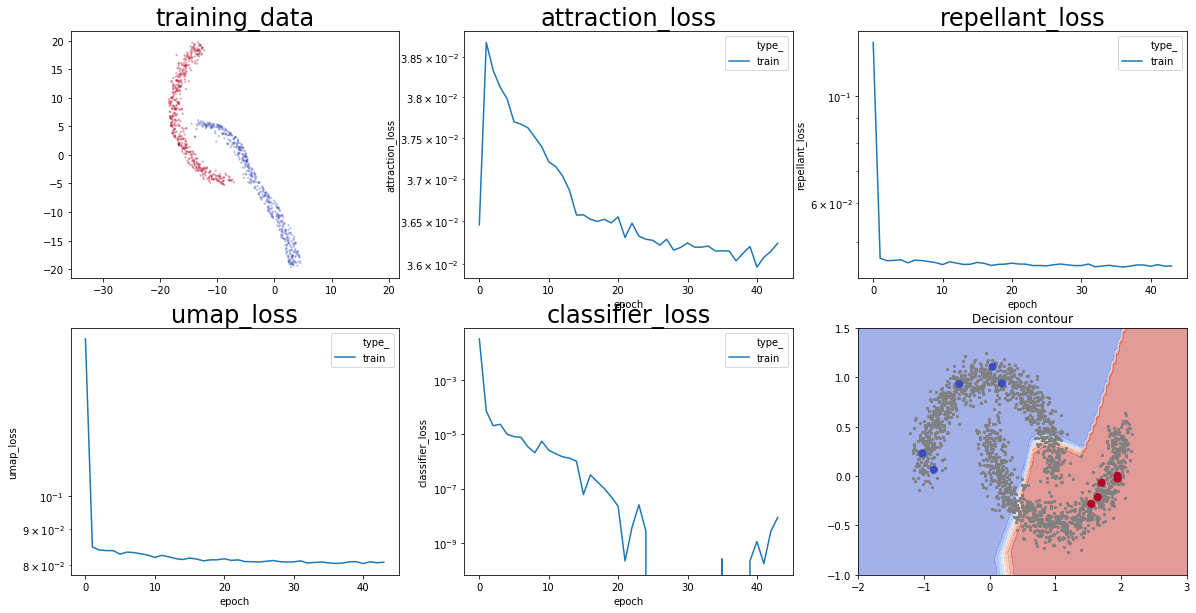

batch: 13720


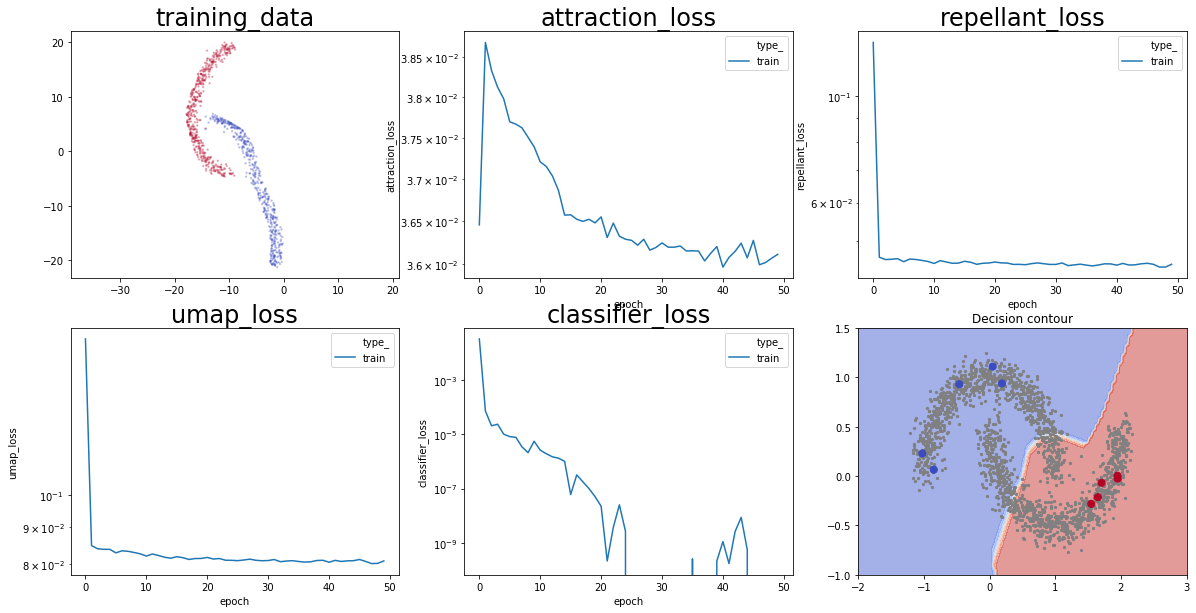

In [45]:
for edge_epoch, epoch in tqdm(zip(edge_iter, np.arange(N_EPOCHS)), total = N_EPOCHS):
    for (batch_to, batch_from), (X, y) in tqdm(zip(edge_epoch, labeled_iter)):
        batch_to = X_train[batch_to]
        batch_from =  X_train[batch_from]
        # train model
        losses = model.train(
            batch_to = batch_to,
            batch_from = batch_from,
            X=X,
            y=y
        );
        model.save_losses(losses, epoch=epoch, type_ = "train") 
    # plot
    if epoch in SAMPLE_EPOCHS:
        print("batch: {}".format(batch))
        plot_results()
    
    
    batch += BATCHES_PER_EPOCH
    #batch_tqdm.update(BATCHES_PER_EPOCH)   